# Assignment 4: Variational Diffusion Models

*Author:* Eric Volkmann / Thomas Adler

*Copyright statement:* This  material,  no  matter  whether  in  printed  or  electronic  form,  may  be  used  for  personal  and non-commercial educational use only.  Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors. 

## Background:

In general latent variable models, we model the latent variables and the observations (data points) by a joint probability distribution $p(x, z)$. In the "likelihood-based" generative modelling setting, we aim to learn a model which maximizes the likelihood $p(x)$ of all data points. If the model is analytically tractable, we can explictly marginalize out the latent variables $z$:

$ p(x) = \int p(x, z) dz $

We derived the maximum likelihood equation for the pPCA model in Assignment 2. For more complex, intractable models this approach fails as we don't have access to the ground truth latent encoder $p(x, z)$.

In the last exercise sheet, we instead derived "Evidence lower bound" (ELBO), which is a lower bound on the evidence and that we can use as proxy objective to optimize our latent variable model, e.g. a simple VAE.

$\log p(x) \geq \mathbb{E} [ \log \frac{p(x,z)}{q_{\phi}(z|x)} ]
            = \underbrace{\mathbb{E}_{q_{\phi}(z|x)} [ \log p_{\theta} (x | z) ]}_{\text{reconstruction term}} - \underbrace{D_{KL} ( q_{\phi}(z | x) || p(z) )}_{\text{prior matching term}}$

In the variational autoencoder case, we learn an intermediate bottlenecking distribution $q_{\phi}(z|x)$ that can be treated as an encoder; it transforms inputs into a distribution over possible latents. Simultaneously, we learn a deterministic function $p_{\theta}(x|z)$ to convert a given latent vector $z$ into an observation $x$, which can be interpreted as a decoder.

In [2]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://i.imgur.com/rBXVRvI.png")

A Hierarchical Variational Autoencoder (HVAE) is a generalization of a VAE that extends to multiple hierarchies over latent variables. Whereas in the general HVAE with $T$ hierarchical levels, each latent is allowed to condition on all previous latents, we focus on a special case which we call a Markovian HVAE (MHVAE). In a MHVAE,
the generative process is a Markov chain; that is, each transition down the hierarchy is Markovian. The generative
process is modeled as a Markov chain, where each latent $z_t$ is generated only from the previous latent $z_{t+1}$.
Intuitively, and visually, this can be seen
as simply stacking VAEs on top of each other. Mathematically, we represent the joint distribution and the posterior of a
Markovian HVAE as:

$p(x, z_{1:T}) = p(z_{T}) p_{\theta}(x|z_1) \prod_{t=2}^{T} p_{\theta}(z_{t-1}|z_{t})$

$q_{\phi}(z_{1:T}|x) = q_{\theta} (z_1 | x) \prod_{t=2}^{T} q_{\theta} (z_{t}|z_{t-1})$

In [3]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://i.imgur.com/teD56gK.png")

The easiest way to think of a Variational Diffusion Model (VDM) is simply as a Markovian Hierarchical Variational Autoencoder with three key restrictions:

 i) The latent dimension is exactly equal to the data dimension
 
 ii) The structure of the latent encoder at each timestep is not learned; it is pre-defined as a linear Gaussian
model. In other words, it is a Gaussian distribution centered around the output of the previous timestep

 iii) The Gaussian parameters of the latent encoders vary over time in such a way that the distribution of
the latent at final timestep T is a standard Gaussian

From the second assumption, we know that the distribution of each latent variable in the encoder is a
Gaussian centered around its previous hierarchical latent.
The main takeaway is that $\alpha_t$ is a (potentially learnable) coefficient that can
vary with the hierarchical depth $t$, for flexibility. Mathematically, encoder transitions are denoted as:

\begin{equation*}
    q(x_t|x_{t-1}) = \mathcal{N}(x_t; \sqrt{\alpha_t} x_{t-1}, (1-\alpha_t) \textbf{I})
\end{equation*}

Note that our encoder distributions $q(x_t|x_{t−1})$ are no longer parameterized by $\phi$, as they are completely
modeled as Gaussians with defined mean and variance parameters at each timestep.

In [4]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://i.imgur.com/VOSpXkR.png")

## Exercise 1) The forward diffusion process (1 pts)

### Exercise 1a) Simulate the forward diffusion process (0.5 pts)

From the first restriction, with some abuse of notation, we can now represent both true data samples and latent variables as $x_t$, where $t = 0$ represents true data samples and $t \in [1, T ]$ represents a corresponding latent with hierarchy indexed by $t$. 

The "encoding process" is referred to as the noise corruption or forward diffusion process in diffusion models

and is defined as
\begin{align*}
    q(x_t \mid x_{t-1}) &= \mathcal N(\sqrt \alpha_t x_{t-1}, (1-\alpha_t) I ) && \text{where} & \alpha_t &\in (0, 1) \subset \mathbb R. 
\end{align*}
If $\alpha_t$ is close to 1, we draw $x_t$ from a normal distribution with mean close to $x_{t-1}$ and small variance. 
Simulate and visualize the forward diffusion process using a sample image from the CIFAR10 dataset for $T=500$. 


Use a fixed $\alpha$ for all time steps. By visual inspection, tune $\alpha$ to a value that lets $x_0$ smoothly blend into noise throughout the sequence.

In [4]:
import math
from math import sqrt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tfm
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    img = (img + 1) / 2 # rescale from [-1, 1] to [0, 1]
    plt.imshow(np.transpose(img.numpy().clip(0, 1), (1, 2, 0)))
    plt.show()

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=tfm.ToTensor())
x = trainset[0][0] * 2 - 1 # scale to [-1, 1]

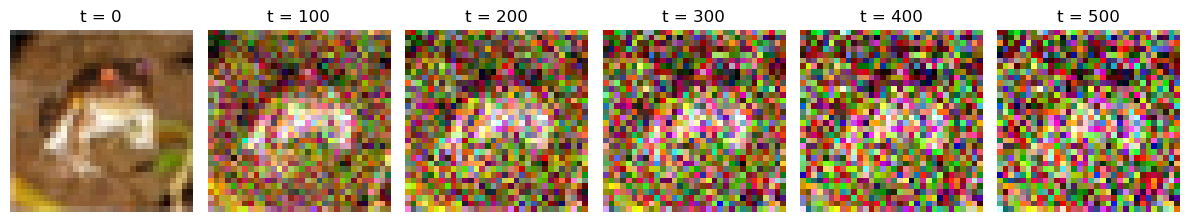

In [ ]:
########## YOUR SOLUTION HERE ##########

T = 500
alpha = 0.999                      
sqrt_alpha = math.sqrt(alpha)
sqrt_1ma   = math.sqrt(1 - alpha)


x_t = x.clone()
saved = {0: x_t.clone()}
checkpoints = [0, 100, 200, 300, 400, 500]

for t in range(1, T + 1):
    noise = torch.randn_like(x_t)
    x_t = sqrt_alpha * x_t + sqrt_1ma * noise
    if t in checkpoints:
        saved[t] = x_t.clone()

fig, axes = plt.subplots(1, len(checkpoints), figsize=(12, 3))
for ax, t in zip(axes, checkpoints):
    img = (saved[t] + 1) / 2                    
    npimg = np.transpose(img.cpu().numpy(), (1, 2, 0)).clip(0,1)
    ax.imshow(npimg)
    ax.set_title(f"t = {t}")
    ax.axis('off')
plt.tight_layout()
plt.show()

### Exercise 1b: Reparametrization trick for the forward process (0.5 pts)

Again, the noise corruption or forward diffusion process, using a fixed $\alpha$ across all timesteps, is defined as
\begin{align*}
    q(x_t \mid x_{t-1}) &= \mathcal N(x_t; \sqrt \alpha x_{t-1}, (1-\alpha) I ) && \text{where} & \alpha &\in (0, 1) \subset \mathbb R. 
\end{align*}
Use the reparameterization trick to show that
\begin{align*}
    q(x_t \mid x_0) = \mathcal N(x_t; \sqrt{\alpha^t} x_0, (1-\alpha^t) I).
\end{align*}
From this result, interpret the role of the parameter $\alpha$. 

########## YOUR SOLUTION HERE ##########

From the distribution description we know that $\mathbb {E} [x_t \mid x_{t-1}] = \sqrt \alpha x_{t-1}$ and $\mathcal Var [x_t \mid x_{t-1}] = (1 - \alpha) I$

use reparameterization trick we can write it as $$x_t = \sqrt \alpha x_{t-1} + \sqrt {1 - \alpha} ϵ_t, ϵ_t \in \mathbb {N} (0 , \mathbb {I})$$

First step: $$x_1 = \sqrt \alpha x_{0} + \sqrt {1 - \alpha} ϵ_1$$

To $t-1$ step: $$x_{t-1} = \sqrt {\alpha^{t-1}} x_{0} + \sqrt {1 - \alpha} \sum_{i=1}^{t-1} \sqrt {\alpha^{t-1-i}} ϵ_i$$

Plugin to t step: 
$$x_t = \sqrt \alpha [\sqrt {\alpha^{t-1}} x_{0} + \sqrt {1 - \alpha} \sum_{i=1}^{t-1} \sqrt {\alpha^{t-1-i}} ϵ_i] + \sqrt {1 - \alpha} ϵ_t$$
$$x_t = \sqrt {\alpha^{t}} x_{0} + \sqrt {1 - \alpha} \sum_{i=1}^{t-1} \sqrt {\alpha^{t-i}} ϵ_i + \sqrt {1 - \alpha} ϵ_t$$
$$x_t = \sqrt {\alpha^{t}} x_{0} + \sqrt {1 - \alpha} \sum_{i=1}^{t} \sqrt {\alpha^{t-i}} ϵ_i$$

Here we arrived $$\mathbb {E} [x_t \mid x_0] = \sqrt {\alpha^{t}} x_{0} $$ Because $ϵ_i$ expectation is $0$)
And $$\mathbb {Var} [x_t \mid x_0] = (1 - \alpha) \sum_{i=1}^{t} \alpha^{t-i} I$$ Because the $\mathbb {Var} ϵ_i = I$

further simplify it: $${Var} [x_t \mid x_0] = (1 - \alpha) \frac {1-\alpha^t}{1-\alpha} I = (1-\alpha^t)I$$

Now we arrived at: $$q(x_t \mid x_0) = \mathcal N(x_t; \sqrt{\alpha^t} x_0, (1-\alpha^t) I)$$

Interpret the role of the parameter $\alpha$:

In each step keep $\sqrt \alpha$ signal, add noise $\sqrt{1-\alpha}$
after t step, original signal reduced to $\sqrt{\alpha^t}$ and total noise added $\mathbb {Var}$ is $1-\alpha^t$
The closer $\alpha$ to 1, the signal keeps longer the process will be more smooth, otherwise the noise will take over faster.


## Exercise 2: A ELBO for VDMs (1.5 pts)

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://i.imgur.com/juJ4KMv.png")

Note that our encoder distributions $q(x_{t}|x_{t−1})$ are no longer parameterized by $\varphi$, as they are completely
modeled as Gaussians with defined mean and variance parameters at each timestep. Therefore, in a VDM, we
are only interested in learning conditionals $p_{\theta} (x_{t-1} | x_{t})$, so that we can simulate new data. After optimizing
the VDM, the sampling procedure is as simple as sampling Gaussian noise from $p(x_T)$ and iteratively running
the denoising transitions $p_{\theta} (x_{t-1}|x_t)$ for $T$ steps to generate a novel $x_0$.

Like any HVAE, the VDM can be optimized by maximizing the ELBO. Derive the ELBO for the VDM and show that it written as follows:

\begin{equation*}
\log p(x_0) \geq \underbrace{\mathbb{E}_{q(x_1|x_0)}[\log p_{\theta}(x_0|x_1)]}_{\text{reconstruction term}}
- \underbrace{\mathbb{E}_{q(x_{T-1}|x_0)}[D_{KL}(q(x_{T}|x_{T-1} || p(x_{T}))]}_{\text{prior matching term}}
- \sum_{t=1}^{T-1} \underbrace{\mathbb{E}_{q(x_{t-1}, x_{t+1}|x_0)} [D_{KL} (q(x_t|x_{t-1}) || p_{\theta}(x_t|x_{t+1}))]}_{\text{consistency term}}
\end{equation*}
Interpret the differents terms.

########## YOUR SOLUTION HERE ##########

We will derive the evidence lower bound (ELBO) for a Variational Diffusion Model (VDM) and show that it decomposes into three intuitive terms: a **reconstruction term**, a **prior matching term**, and a **consistency term**.

---

## 1. General ELBO for a Hierarchical Latent Variable Model

For any hierarchical latent model with observed \(x_0\) and latents \(x_{1:T}\), we have
$$
\log p(x_0) \;=\;\log \int p(x_{0:T})\,dx_{1:T}
\;\ge\;
\mathbb{E}_{q(x_{1:T}\mid x_0)}\Bigl[\log\frac{p(x_{0:T})}{q(x_{1:T}\mid x_0)}\Bigr].
$$

In a VDM (i.e. a Markovian HVAE) the **generative model** and the **encoder** factorize as
$$
p(x_{0:T}) = p(x_T)\prod_{t=1}^T p_\theta(x_{t-1}\mid x_t),
\quad
q(x_{1:T}\mid x_0) = \prod_{t=1}^T q(x_t\mid x_{t-1}).
$$

---

## 2. Plugging in and Rearranging

1. **Expand the ELBO**  
   $$
   \begin{aligned}
   \log p(x_0)
   &\ge
   \mathbb{E}_{q}\Bigl[\log p(x_T)
     + \sum_{t=1}^T \log p_\theta(x_{t-1}\mid x_t)
     - \sum_{t=1}^T \log q(x_t\mid x_{t-1})
   \Bigr]\\
   &=
   \underbrace{\mathbb{E}_{q(x_1\mid x_0)}[\log p_\theta(x_0\mid x_1)]}_{\text{reconstruction}}
   \;+\;
   \sum_{t=2}^T \mathbb{E}_{q(x_{t-1},x_t\mid x_0)}[\log p_\theta(x_{t-1}\mid x_t)]\\
   &\quad
   \;-\;
   \sum_{t=1}^T \mathbb{E}_{q(x_{t-1},x_t\mid x_0)}[\log q(x_t\mid x_{t-1})]
   \;+\;\mathbb{E}_{q(x_{T-1}\mid x_0)}[\log p(x_T)].
   \end{aligned}
   $$

2. **Identify KL terms**  
   - **Prior matching** (last step \(t=T\)):  
     $$
     \mathbb{E}_{q(x_{T-1}\mid x_0)}\Bigl[\log p(x_T) - \log q(x_T\mid x_{T-1})\Bigr]
     = -\,\mathbb{E}_{q(x_{T-1}\mid x_0)}\bigl[D_{KL}(q(x_T\mid x_{T-1})\Vert p(x_T))\bigr].
     $$
   - **Consistency** (intermediate steps \(1\le t\le T-1\)):  
     $$
     \begin{aligned}
     &\mathbb{E}_{q(x_{t-1},x_t\mid x_0)}[\log p_\theta(x_{t-1}\mid x_t)]
       \;-\;\mathbb{E}_{q(x_{t-1},x_t\mid x_0)}[\log q(x_t\mid x_{t-1})]\\
     &\quad = -\,\mathbb{E}_{q(x_{t-1},x_{t+1}\mid x_0)}\bigl[D_{KL}(q(x_t\mid x_{t-1})\Vert p_\theta(x_t\mid x_{t+1}))\bigr].
     \end{aligned}
     $$

Collecting everything, we obtain the final bound:

$$
\log p(x_0)
\;\ge\;
\underbrace{\mathbb{E}_{q(x_1\mid x_0)}[\log p_\theta(x_0\mid x_1)]}_{\text{Reconstruction term}}
\;-\;
\underbrace{\mathbb{E}_{q(x_{T-1}\mid x_0)}\bigl[D_{KL}(q(x_T\mid x_{T-1})\Vert p(x_T))\bigr]}_{\text{Prior matching term}}
\;-\;
\sum_{t=1}^{T-1}
\underbrace{\mathbb{E}_{q(x_{t-1},x_{t+1}\mid x_0)}
\bigl[D_{KL}(q(x_t\mid x_{t-1})\Vert p_\theta(x_t\mid x_{t+1}))\bigr]}_{\text{Consistency term}}.
$$

---

## 3. Interpretation of Each Term

1. **Reconstruction term**  
   - Measures how well the model can reconstruct the original \(x_0\) from the first noisy latent \(x_1\).

2. **Prior matching term**  
   - Ensures that the final latent \(x_T\) produced by the forward diffusion process matches the chosen prior \(p(x_T)\), typically a standard Gaussian.

3. **Consistency term**  
   - Enforces that each forward step \(q(x_t\mid x_{t-1})\) is consistent with the learned reverse step \(p_\theta(x_t\mid x_{t+1})\), so that the model can reliably denoise layer by layer.

This completes the detailed derivation in a VDM context.


## Exercise 3: A smarter ELBO for VDMs (1.5 pts)

In [9]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://i.imgur.com/Q08pjU3.png")

The terms in the ELBO are expectations and are typcially computed using Monte Carlo estimates.

Unfortunately, optimizing the ELBO using the terms we just derived might be suboptimal: The consistency term is computed as an expectation over two random variables
${x_{t−1}, x_{t+1}}$ for every timestep and the variance of its Monte Carlo estimate could potentially be higher than a term that is estimated using only one random variable per timestep. As it is computed by summing up $T − 1$ consistency terms, the final estimated value of the ELBO may have high variance for large $T$ values.

The key insight is that we can rewrite encoder transitions as $q(x_{t}|x_{t−1}) = q(x_t|x_{t−1}, x_0)$, where the extra conditioning term is superfluous due to the Markov property. Then, according to Bayes rule, we can rewrite each transition as:

\begin{equation*}
    q(x_t|x_{t-1}, x_0)  = \frac{q(x_{t-1}|x_t, x_0) q(x_t|x_0)}{q(x_{t-1}|x_0)}
\end{equation*}

Retry the derivation of the ELBO using this equation and show that it can be written as follows:

\begin{equation*}
\log p(x_0) \geq \underbrace{\mathbb{E}_{q(x_1|x_0)}[\log p_{\theta}(x_0|x_1)]}_{\text{reconstruction term}}
- \underbrace{D_{KL}(q(x_{T}|x_{0}) || p(x_{T}))}_{\text{prior matching term}}
- \sum_{t=2}^{T} \underbrace{\mathbb{E}_{q(x_{t}|x_0)} [D_{KL} (q(x_{t-1}|x_{t},x_0) || p_{\theta}(x_{t-1}|x_{t}))]}_{\text{denoising matching term}}
\end{equation*}

Again, provide interpretations for the terms and argue if and why this is a better or worse optimization target than the previous ELBO.

########## YOUR SOLUTION HERE ##########

# ELBO Derivation with Low-Variance “Denoising Matching” Form

We now derive an alternative ELBO for the Variational Diffusion Model (VDM) by using the identity
$$
q(x_t \mid x_{t-1})
= q(x_t\mid x_{t-1},x_0)
= \frac{q(x_{t-1}\mid x_t,x_0)\,q(x_t\mid x_0)}{q(x_{t-1}\mid x_0)}.
$$
This lets us express each forward step in terms of two distributions each conditioned only on $x_0$ and one of $\{x_{t-1},x_t\}$, which reduces variance in Monte Carlo estimates.

---

## 1. Start from the general ELBO

For any latent chain $x_{1:T}$ we have
$$
\log p(x_0)
\;=\;\log\int p(x_{0:T})\,dx_{1:T}
\;\ge\;
\mathbb{E}_{q(x_{1:T}\mid x_0)}\Bigl[\log\frac{p(x_{0:T})}{q(x_{1:T}\mid x_0)}\Bigr].
$$

In the VDM,
$$
p(x_{0:T})
= p(x_T)\prod_{t=1}^T p_\theta(x_{t-1}\mid x_t),
\quad
q(x_{1:T}\mid x_0)
= \prod_{t=1}^T q(x_t\mid x_{t-1}).
$$

---

## 2. Rewrite each forward term using Bayes’ rule

For each $t=2,\dots,T$,
$$
q(x_t\mid x_{t-1})
= \frac{q(x_{t-1}\mid x_t,x_0)\,q(x_t\mid x_0)}{q(x_{t-1}\mid x_0)}.
$$
Hence
$$
\log q(x_t\mid x_{t-1})
= \log q(x_{t-1}\mid x_t,x_0)
+ \log q(x_t\mid x_0)
- \log q(x_{t-1}\mid x_0).
$$

---

## 3. Substitute into the ELBO

1. **Expand the ELBO**  
   $$
   \begin{aligned}
   \mathcal L
   &=\mathbb{E}_{q}\Bigl[\sum_{t=1}^T \log p_\theta(x_{t-1}\mid x_t)
   \;+\;\log p(x_T)
   \;-\;\sum_{t=1}^T \log q(x_t\mid x_{t-1})\Bigr]\\
   &=\underbrace{\mathbb{E}_{q(x_1\mid x_0)}[\log p_\theta(x_0\mid x_1)]}_{\text{reconstruction}}
   +\sum_{t=2}^T \mathbb{E}_q[\log p_\theta(x_{t-1}\mid x_t)]
   +\mathbb{E}_{q(x_{T-1}\mid x_0)}[\log p(x_T)]\\
   &\quad
   -\sum_{t=2}^T \mathbb{E}_q\bigl[\log q(x_{t-1}\mid x_t,x_0)
     +\log q(x_t\mid x_0)
     -\log q(x_{t-1}\mid x_0)\bigr]
   -\mathbb{E}_{q(x_1\mid x_0)}[\log q(x_1\mid x_0)].
   \end{aligned}
   $$

2. **Cancel telescoping terms**  
   Notice that the sum over $t=2\dots T$ of
   $$
   -\mathbb{E}_q\bigl[\log q(x_t\mid x_0)\bigr]
   +\mathbb{E}_q\bigl[\log q(x_{t-1}\mid x_0)\bigr]
   $$
   collapses, leaving only
   $$
   -\mathbb{E}_{q(x_1\mid x_0)}[\log q(x_1\mid x_0)]
   +\mathbb{E}_{q(x_{T-1}\mid x_0)}[\log q(x_{T-1}\mid x_0)]
   -\mathbb{E}_{q(x_{T-1}\mid x_0)}[\log q(x_T\mid x_{T-1})].
   $$

3. **Group into KL divergences**  
   - **Prior matching** at $t=T$:  
     $$
     \mathbb{E}_{q(x_{T-1}\mid x_0)}[\log p(x_T)
       -\log q(x_T\mid x_{T-1})]
     = -D_{KL}\bigl(q(x_T\mid x_0)\,\|\,p(x_T)\bigr).
     $$
   - **Denoising matching** for each $t=2,\dots,T$:  
     $$
     \begin{aligned}
     &\mathbb{E}_{q(x_t\mid x_0)}\bigl[\log p_\theta(x_{t-1}\mid x_t)
       -\mathbb{E}_{q(x_{t-1}\mid x_t,x_0)}[\log q(x_{t-1}\mid x_t,x_0)]\bigr]\\
     &\quad = -\,\mathbb{E}_{q(x_t\mid x_0)}\bigl[D_{KL}\bigl(q(x_{t-1}\mid x_t,x_0)\,\|\,p_\theta(x_{t-1}\mid x_t)\bigr)\bigr].
     \end{aligned}
     $$

Putting everything together yields the low-variance ELBO:

---

## 4. Final ELBO and Interpretation

$$
\boxed{
\log p(x_0)
\;\ge\;
\underbrace{\mathbb{E}_{q(x_1\mid x_0)}[\log p_\theta(x_0\mid x_1)]}_{\text{reconstruction}}
\;-\;
\underbrace{D_{KL}(q(x_T\mid x_0)\,\|\,p(x_T))}_{\text{prior matching}}
\;-\;
\sum_{t=2}^T
\underbrace{\mathbb{E}_{q(x_t\mid x_0)}\bigl[D_{KL}(q(x_{t-1}\mid x_t,x_0)\,\|\,p_\theta(x_{t-1}\mid x_t))\bigr]}_{\text{denoising matching}}.
}
$$

- **Reconstruction term**  
  Measures how well the model reconstructs $x_0$ from its first noisy version $x_1$.

- **Prior matching term**  
  Forces the marginal $q(x_T\mid x_0)$ to match the chosen prior $p(x_T)$ (usually $\mathcal N(0,I)$).

- **Denoising matching term**  
  For each $t$, ensures the learned reverse kernel $p_\theta(x_{t-1}\mid x_t)$ aligns with the true posterior $q(x_{t-1}\mid x_t,x_0)$, while only sampling $x_t$ from $q(x_t\mid x_0)$, reducing variance.

---

## 5. Why lower variance?

- **Original ELBO** used expectations over pairs $(x_{t-1},x_{t+1})$ per step, which increases Monte Carlo noise.  
- **New form** only requires sampling a single $x_t$ per step to estimate each KL, leading to more stable gradient estimates when $T$ is large.

This completes the detailed derivation and comparison of the two ELBO forms for a VDM.  


## Exercise 4: Backward Diffusion Process (2 pts)

To instantiate this objective we need to determine the distribution $q(x_{t-1} \mid x_t, x_0)$, which can be thought of as the backward diffusion process.

We know that $q(x_t|x_{t-1}) = \mathcal{N}(x_t; \sqrt{\alpha_t} x_{t-1}, (1-\alpha_t) \textbf{I})$


Show that 
\begin{align*}
    q(x_{t-1} \mid x_t, x_0) = \mathcal N\left(x_{t-1}; \frac1{1-\alpha^t} \left( \sqrt \alpha (1-\alpha^{t-1}) x_t + \sqrt{\alpha^{t-1}} (1-\alpha) x_0 \right), \frac{(1-\alpha)(1-\alpha^{t-1})}{1-\alpha^t}\right).
\end{align*}

Assume constant $\alpha = \alpha_t$  $\forall t \in [0, T]$.

*Hint: Use the result for Exercise 1b) and the conditional version of Bayes' theorem*

########## YOUR SOLUTION HERE ##########

# Derivation of the Backward Diffusion Distribution  
We wish to derive the closed-form for  
$$
q(x_{t-1}\mid x_t, x_0)
$$  
given the forward noising kernels and the marginal from Exercise 1.

---

## 1. Bayes’ rule for Markov chain  
Because of the Markov property  
$$
q(x_t\mid x_{t-1},x_0) = q(x_t\mid x_{t-1}),
$$  
we can write  
$$
q(x_{t-1}\mid x_t, x_0)
= \frac{q(x_t\mid x_{t-1},x_0)\,q(x_{t-1}\mid x_0)}{q(x_t\mid x_0)}
= \frac{q(x_t\mid x_{t-1})\,q(x_{t-1}\mid x_0)}{q(x_t\mid x_0)}.
$$

---

## 2. Insert known Gaussians  
1. **Forward kernel**  
   $$
   q(x_t\mid x_{t-1})
   = \mathcal{N}\bigl(x_t;\,\sqrt\alpha\,x_{t-1},\;(1-\alpha)\,I\bigr).
   $$
2. **Marginal at \(t-1\)** (from Exercise 1)  
   $$
   q(x_{t-1}\mid x_0)
   = \mathcal{N}\bigl(x_{t-1};\,\sqrt{\alpha^{\,t-1}}\,x_0,\;(1-\alpha^{\,t-1})\,I\bigr).
   $$
3. **Marginal at \(t\)** (from Exercise 1)  
   $$
   q(x_t\mid x_0)
   = \mathcal{N}\bigl(x_t;\,\sqrt{\alpha^t}\,x_0,\;(1-\alpha^t)\,I\bigr).
   $$

Thus the unnormalized posterior is the product of two Gaussians divided by a third.

---

## 3. Posterior as Gaussian via “precision” addition  
A product of Gaussians  
$$
\mathcal{N}(z;\mu_1,\Sigma_1)\,\times\,\mathcal{N}(z;\mu_2,\Sigma_2)
\;\propto\;\mathcal{N}\bigl(z;\,\Sigma\,( \Sigma_1^{-1}\mu_1 + \Sigma_2^{-1}\mu_2 ),\;\Sigma\bigr)
$$  
with  
$$
\Sigma = \bigl(\Sigma_1^{-1} + \Sigma_2^{-1}\bigr)^{-1}.
$$  
Apply this to  
\[
q(x_{t-1}\mid x_t,x_0)\;\propto\;
\underbrace{\mathcal{N}(x_{t-1};\,\tfrac{1}{\sqrt\alpha}x_t,\,(1-\alpha)I)}_{\text{“likelihood”}}
\;\times\;
\underbrace{\mathcal{N}(x_{t-1};\,\sqrt{\alpha^{\,t-1}}x_0,\,(1-\alpha^{\,t-1})I)}_{\text{“prior”}}.
\]  
Here we have re-expressed the forward kernel as  
$$
q(x_t\mid x_{t-1})
= \mathcal N\bigl(x_{t-1};\,\tfrac1{\sqrt\alpha}x_t,\,(1-\alpha)I\bigr)
$$  
for the purposes of multiplying Gaussians.

---

### 3.1 Compute the posterior covariance  
- Precision from the likelihood:  
  $$
  \Sigma_{\text{lik}}^{-1} = \frac{1}{1-\alpha}\,I.
  $$
- Precision from the prior:  
  $$
  \Sigma_{\text{prior}}^{-1}
  = \frac{1}{1-\alpha^{\,t-1}}\,I.
  $$
- Sum of precisions:  
  $$
  \Sigma^{-1}
  = \frac{1}{1-\alpha} + \frac{1}{1-\alpha^{\,t-1}}
  = \frac{(1-\alpha^{\,t-1}) + (1-\alpha)}{(1-\alpha)(1-\alpha^{\,t-1})}\,I
  = \frac{1-\alpha^t}{(1-\alpha)(1-\alpha^{\,t-1})}\,I.
  $$
- Therefore the posterior covariance is  
  $$
  \Sigma
  = \frac{(1-\alpha)(1-\alpha^{\,t-1})}{1-\alpha^t}\,I.
  $$

---

### 3.2 Compute the posterior mean  
The combined precision-weighted mean is
$$
\Sigma\Bigl(\Sigma_{\text{lik}}^{-1}\,\underbrace{\tfrac1{\sqrt\alpha}x_t}_{\mu_{\text{lik}}}
\;+\;\Sigma_{\text{prior}}^{-1}\,\underbrace{\sqrt{\alpha^{\,t-1}}x_0}_{\mu_{\text{prior}}}\Bigr).
$$
Plug in:
$$
\begin{aligned}
\mu
&= \frac{(1-\alpha)(1-\alpha^{\,t-1})}{1-\alpha^t}
\left(
\frac{1}{1-\alpha}\,\frac{x_t}{\sqrt\alpha}
\;+\;\frac{1}{1-\alpha^{\,t-1}}\,\sqrt{\alpha^{\,t-1}}\,x_0
\right)\\[6pt]
&= \frac{1}{1-\alpha^t}
\Bigl(
\sqrt\alpha\,(1-\alpha^{\,t-1})\,x_t
\;+\;\sqrt{\alpha^{\,t-1}}\,(1-\alpha)\,x_0
\Bigr).
\end{aligned}
$$

---

## 4. Final result  

Putting covariance and mean together, we obtain
$$
\boxed{
q(x_{t-1}\mid x_t, x_0)
= \mathcal{N}\!\biggl(
x_{t-1};
\frac{1}{1-\alpha^t}\bigl[\sqrt\alpha\,(1-\alpha^{\,t-1})\,x_t
  + \sqrt{\alpha^{\,t-1}}\,(1-\alpha)\,x_0\bigr],
\;\frac{(1-\alpha)(1-\alpha^{\,t-1})}{1-\alpha^t}\,I
\biggr).
}
$$

This completes the detailed derivation.  


## Exercise 5: Training (2 pts)

Now that we know $q(x_{t-1} \mid x_t, x_0)$, we can construct $p_\theta(x_{t-1} \mid x_t)$ by letting our model predict $x_0$ and plugging that prediction into the solution for $q(x_{t-1} \mid x_t, x_0)$. 

Since both $q(x_{t-1} \mid x_t, x_0)$ and $p_\theta(x_{t-1} \mid x_t)$ are Gaussian, maximizing the ELBO results in minimizing the mean-squared error. 

Implement a training loop for the network specified below. 

Do a uniform Monte-Carlo estimate over $t$, i.e., for each sample, draw a time step $t$ uniformly from ${1, \dots, T}$ and corrupt the image accordingly to obtain $x_t$. 
Then train the VDM to predict $\varepsilon$ from $x_t$, i.e. minimize the MSE between the ground truth image $x_0$ and the predicted image $\hat{x}_0$.

For efficiency reasons, we share the model parameters over time. 
To improve performance, we feed $t$ as an additional input alongside $x_t$. 
The provided hyperparameters should work to get "ok" results but feel free to experiment with them as always. 

1547337 parameters
Epoch 1/200, Loss: 0.047290
Epoch 2/200, Loss: 0.025064
Epoch 3/200, Loss: 0.022893
Epoch 4/200, Loss: 0.022256
Epoch 5/200, Loss: 0.021868
Epoch 6/200, Loss: 0.020961
Epoch 7/200, Loss: 0.020464
Epoch 8/200, Loss: 0.020147
Epoch 9/200, Loss: 0.020002
Epoch 10/200, Loss: 0.019733
Epoch 11/200, Loss: 0.019444
Epoch 12/200, Loss: 0.019374
Epoch 13/200, Loss: 0.019328
Epoch 14/200, Loss: 0.019087
Epoch 15/200, Loss: 0.019075
Epoch 16/200, Loss: 0.018892
Epoch 17/200, Loss: 0.018903
Epoch 18/200, Loss: 0.018793
Epoch 19/200, Loss: 0.018757
Epoch 20/200, Loss: 0.018668
Epoch 21/200, Loss: 0.018686
Epoch 22/200, Loss: 0.018504
Epoch 23/200, Loss: 0.018451
Epoch 24/200, Loss: 0.018387
Epoch 25/200, Loss: 0.018410
Epoch 26/200, Loss: 0.018439
Epoch 27/200, Loss: 0.018330
Epoch 28/200, Loss: 0.018350
Epoch 29/200, Loss: 0.018215
Epoch 30/200, Loss: 0.018268
Epoch 31/200, Loss: 0.018190
Epoch 32/200, Loss: 0.018166
Epoch 33/200, Loss: 0.018059
Epoch 34/200, Loss: 0.018051
Epoc

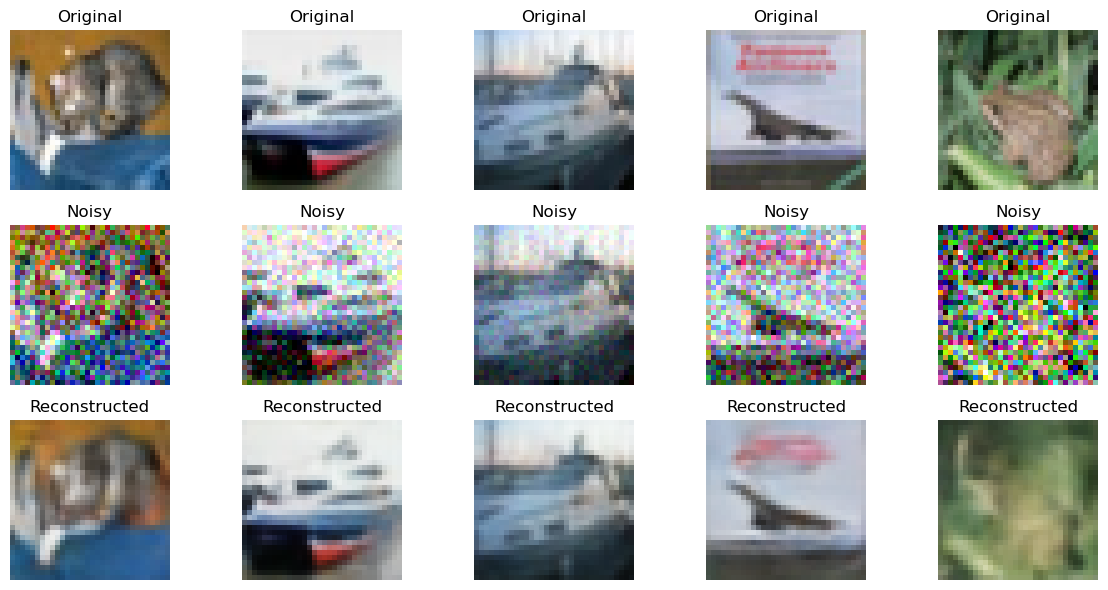

In [ ]:
batch_size = 128
epochs = 200
lr = 1e-3
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=tfm.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=tfm.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

class VDM(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(4, 32, 4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.deconv1 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)
        self.debn1 = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(256, 64, 4, stride=2, padding=1)
        self.debn2 = nn.BatchNorm2d(64)
        self.deconv3 = nn.ConvTranspose2d(128, 32, 4, stride=2, padding=1)
        self.debn3 = nn.BatchNorm2d(32)
        self.deconv4 = nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1)
        self.debn4 = nn.BatchNorm2d(3)

    def forward(self, x, t):
        #t = torch.ones_like(x[:, :1, :, :]) * (t/T * 2 - 1)
        #x0 = torch.cat([x, t], 1)

        # x: (B, 3, H, W), t: (B,)
        B, _, H, W = x.shape

        t_norm = (t / T * 2 - 1).view(B, 1, 1, 1)            # (B,1,1,1)
        t_embed = t_norm.expand(B, 1, H, W)                  # (B,1,H,W)

        x0 = torch.cat([x, t_embed], dim=1)                  # (B,4,H,W)




        x1 = F.relu(self.bn1(self.conv1(x0)))
        x2 = F.relu(self.bn2(self.conv2(x1)))
        x3 = F.relu(self.bn3(self.conv3(x2)))
        x4 = F.relu(self.bn4(self.conv4(x3)))
        x4 = F.relu(self.debn1(self.deconv1(x4)))
        x3 = F.relu(self.debn2(self.deconv2(torch.cat([x4, x3], 1))))
        x2 = F.relu(self.debn3(self.deconv3(torch.cat([x3, x2], 1))))
        return F.tanh(self.debn4(self.deconv4(torch.cat([x2, x1], 1))))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
vdm = VDM().to(device)
vdm.train()
optimizer = torch.optim.Adam(vdm.parameters(), lr=lr)
print(torch.nn.utils.parameters_to_vector(vdm.parameters()).numel(), 'parameters')

########## YOUR SOLUTION HERE ##########

# Training loop
for epoch in range(1, epochs + 1):
    vdm.train()
    running_loss = 0.0
    for images, _ in trainloader:
        # Scale images to [-1, 1]
        x0 = images.to(device) * 2 - 1  

        # Sample random timesteps for each image
        t = torch.randint(1, T + 1, (x0.size(0),), device=device)

        # Compute alpha^t, sqrt_alpha_t and sqrt_one_minus_alpha_t
        alpha_t = alpha ** t.float()
        sqrt_alpha_t = torch.sqrt(alpha_t).view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_t = torch.sqrt(1 - alpha_t).view(-1, 1, 1, 1)

        # Forward diffusion: sample x_t
        noise = torch.randn_like(x0)
        x_t = sqrt_alpha_t * x0 + sqrt_one_minus_alpha_t * noise

        # Predict x0 from x_t and t
        x0_pred = vdm(x_t, t.float())

        # Compute loss (MSE between true x0 and predicted)
        loss = F.mse_loss(x0_pred, x0)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x0.size(0)

    avg_loss = running_loss / len(trainloader.dataset)
    print(f"Epoch {epoch}/{epochs}, Loss: {avg_loss:.6f}")

# Display a test example: original, noisy, and reconstruction
vdm.eval()
with torch.no_grad():
    test_images, _ = next(iter(testloader))
    x0_test = test_images.to(device) * 2 - 1
    t_test = torch.randint(1, T + 1, (x0_test.size(0),), device=device)
    alpha_t_test = alpha ** t_test.float()
    sqrt_alpha_t_test = torch.sqrt(alpha_t_test).view(-1, 1, 1, 1)
    sqrt_one_minus_alpha_t_test = torch.sqrt(1 - alpha_t_test).view(-1, 1, 1, 1)
    noise_test = torch.randn_like(x0_test)
    x_t_test = sqrt_alpha_t_test * x0_test + sqrt_one_minus_alpha_t_test * noise_test
    x0_recon = vdm(x_t_test, t_test.float())

# Visualize
fig, axes = plt.subplots(3, 5, figsize=(12, 6))
for i in range(5):
    # Original
    img = (x0_test[i] + 1) / 2
    axes[0, i].imshow(img.cpu().permute(1, 2, 0).clip(0, 1))
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')

    # Noisy
    img = (x_t_test[i] + 1) / 2
    axes[1, i].imshow(img.cpu().permute(1, 2, 0).clip(0, 1))
    axes[1, i].set_title("Noisy")
    axes[1, i].axis('off')

    # Reconstruction
    img = (x0_recon[i] + 1) / 2
    axes[2, i].imshow(img.cpu().permute(1, 2, 0).clip(0, 1))
    axes[2, i].set_title("Reconstructed")
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

## Bonus Exercise: Inference and Visualization (1 pts)

The key idea of diffusion models is to generate images by performing the backward diffusion process using our trained model to predict $x_0$. 
That is, at time $t$, sample $x_{t-1}$ from  
\begin{align*}
    p(x_{t-1} \mid x_t, \hat x_0) = \mathcal N\left(\frac1{1-\alpha^t} \left( \sqrt \alpha (1-\alpha^{t-1}) x_t + \sqrt{\alpha^{t-1}} (1-\alpha) \hat x_0 \right), \frac{(1-\alpha)(1-\alpha^{t-1})}{1-\alpha^t} I\right)
\end{align*}
where $\hat x_0$ is the model prediction from $x_t$. 

Iterate this scheme from $t=T$ until $t=0$ to generate a bunch of sample images.

Visualize the denoising process of going from pure noise to a sample image (inverse of exercise 1a). Plot either a sequence of images or make a short animation.

In [ ]:
########## YOUR SOLUTION HERE ##########

import numpy as np
import torch
import torchvision
import imageio
import matplotlib.pyplot as plt


grid_size  = 4      # 4×4 网格
num_frames = 20     # GIF 帧数
fps        = 5      # 每秒帧数
out_path   = 'diffusion_grid.gif'

# 2. 选帧：从 T 均匀到 0
timesteps = np.linspace(T, 0, num_frames, dtype=int)
save_set  = set(timesteps.tolist())

# 3. 初始化 16 个纯噪声样本
batch_size = grid_size * grid_size
x_t = torch.randn(batch_size, 3, 32, 32, device=device)

frames = []
# 4. 反向扩散过程
for t in range(T, 0, -1):
    # 模型预测 x0_hat
    t_batch = torch.full((batch_size,), t, device=device, dtype=torch.float32)
    with torch.no_grad():
        x0_hat = vdm(x_t, t_batch)

    # 计算后验均值和方差
    alpha_t       = alpha ** t
    alpha_t_minus = alpha ** (t - 1)
    coef1 = np.sqrt(alpha) * (1 - alpha_t_minus)
    coef2 = np.sqrt(alpha_t_minus) * (1 - alpha)
    denom = 1 - alpha_t

    mean = (coef1 * x_t + coef2 * x0_hat) / denom
    var  = (1 - alpha) * (1 - alpha_t_minus) / denom
    std  = np.sqrt(var)

    # 采样 x_{t-1}
    noise = torch.randn_like(x_t)
    x_t = mean + std * noise

    # 若此步是记录点，则渲染并保存网格
    if t in save_set:
        grid = torchvision.utils.make_grid((x_t + 1) / 2, nrow=grid_size)
        img  = (grid.cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        frames.append(img)

# 5. 保存为 GIF
imageio.mimsave(out_path, frames, fps=fps)
print(f"Saved {len(frames)} frames GIF → {out_path}")


Saved 19 frames GIF → diffusion_grid.gif
